In [370]:
library('dplyr')
library('tidyr')
library('ggplot2')
library("rvest")
library('stringr')

options(repr.plot.widht=4, repr.plot.height=4, repr.plot.res = 300)

In [371]:
## Lee información demográfica de comunas
webpage <- read_html("https://es.wikipedia.org/wiki/Anexo:Comunas_de_Chile")
table <- html_nodes(webpage, "table")
raw_data <- html_table(table[[1]], trim=TRUE, fill=TRUE, dec=",")
names(raw_data) <- c('Codigo.comuna','Comuna','columna','provincia','region','superficie','poblacion','densidad','IDH.2005','IDH.2005.texto','latitud','longitud' )

comunas <- read.csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19.csv",
                   sep=',', header = TRUE, na.strings="-")
comunas <- comunas %>%
    mutate(Reales = round(comunas$Tasa*comunas$Poblacion/100000),
           Codigo.comuna = replace(Codigo.comuna, Comuna == 'Coyhaique', 11101),
           Codigo.comuna = replace(Codigo.comuna, Comuna == 'OHiggins', 11302)
          )

demografia <- raw_data %>%
    mutate(superficie = gsub('[[:space:]]', '', superficie)) %>%
    mutate(superficie = gsub('8.599,5','8599.5', superficie)) %>%
    mutate(superficie = as.numeric(sub(',','.',superficie, fixed = TRUE))) %>%
    select(superficie,IDH = IDH.2005, Codigo.comuna)

In [372]:
data_epi <- left_join(comunas, demografia, by="Codigo.comuna") %>% 
    mutate(densidad = Poblacion/superficie)

In [373]:
data <- read.csv("Documents/covid_19_chile.csv",sep=";")

x <- tail(data$Dia, n=1)
newdata <- data.frame(Dia=c(0:x))

In [374]:
data <- data %>%
    mutate(Totales = cumsum(data$Nuevos))

data <- data %>%
    mutate(fatality.rate = data$Fallecidos/data$Totales*100) %>%
    mutate(positive.rate = data$Nuevos/data$Testeos*100) %>%
    mutate(positive.rate.cum = data$Totales/data$Testeos.Totales*100) %>%
    mutate(Activos = data$Totales - data$Recuperados - data$Fallecidos)

Nonlinear regression model
  model: Nuevos ~ a * exp(b * Dia) + c
   data: data
         a          b          c 
 775.55211    0.01195 -832.75150 
 residual sum-of-squares: 137914

Number of iterations to convergence: 11 
Achieved convergence tolerance: 1.646e-06


	Shapiro-Wilk normality test

data:  predict(model2, newdata) - data$Nuevos
W = 0.9814, p-value = 0.7028


Nonlinear regression model
  model: Nuevos ~ a * exp(b * Dia) + c
   data: data[-c(17, 26, 29, 32, 34, 37, 40:42), ]
         a          b          c 
 390.19514    0.01942 -435.58119 
 residual sum-of-squares: 58612

Number of iterations to convergence: 12 
Achieved convergence tolerance: 4.609e-06


	Shapiro-Wilk normality test

data:  predict(model3, newdata) - data$Nuevos
W = 0.97012, p-value = 0.3192


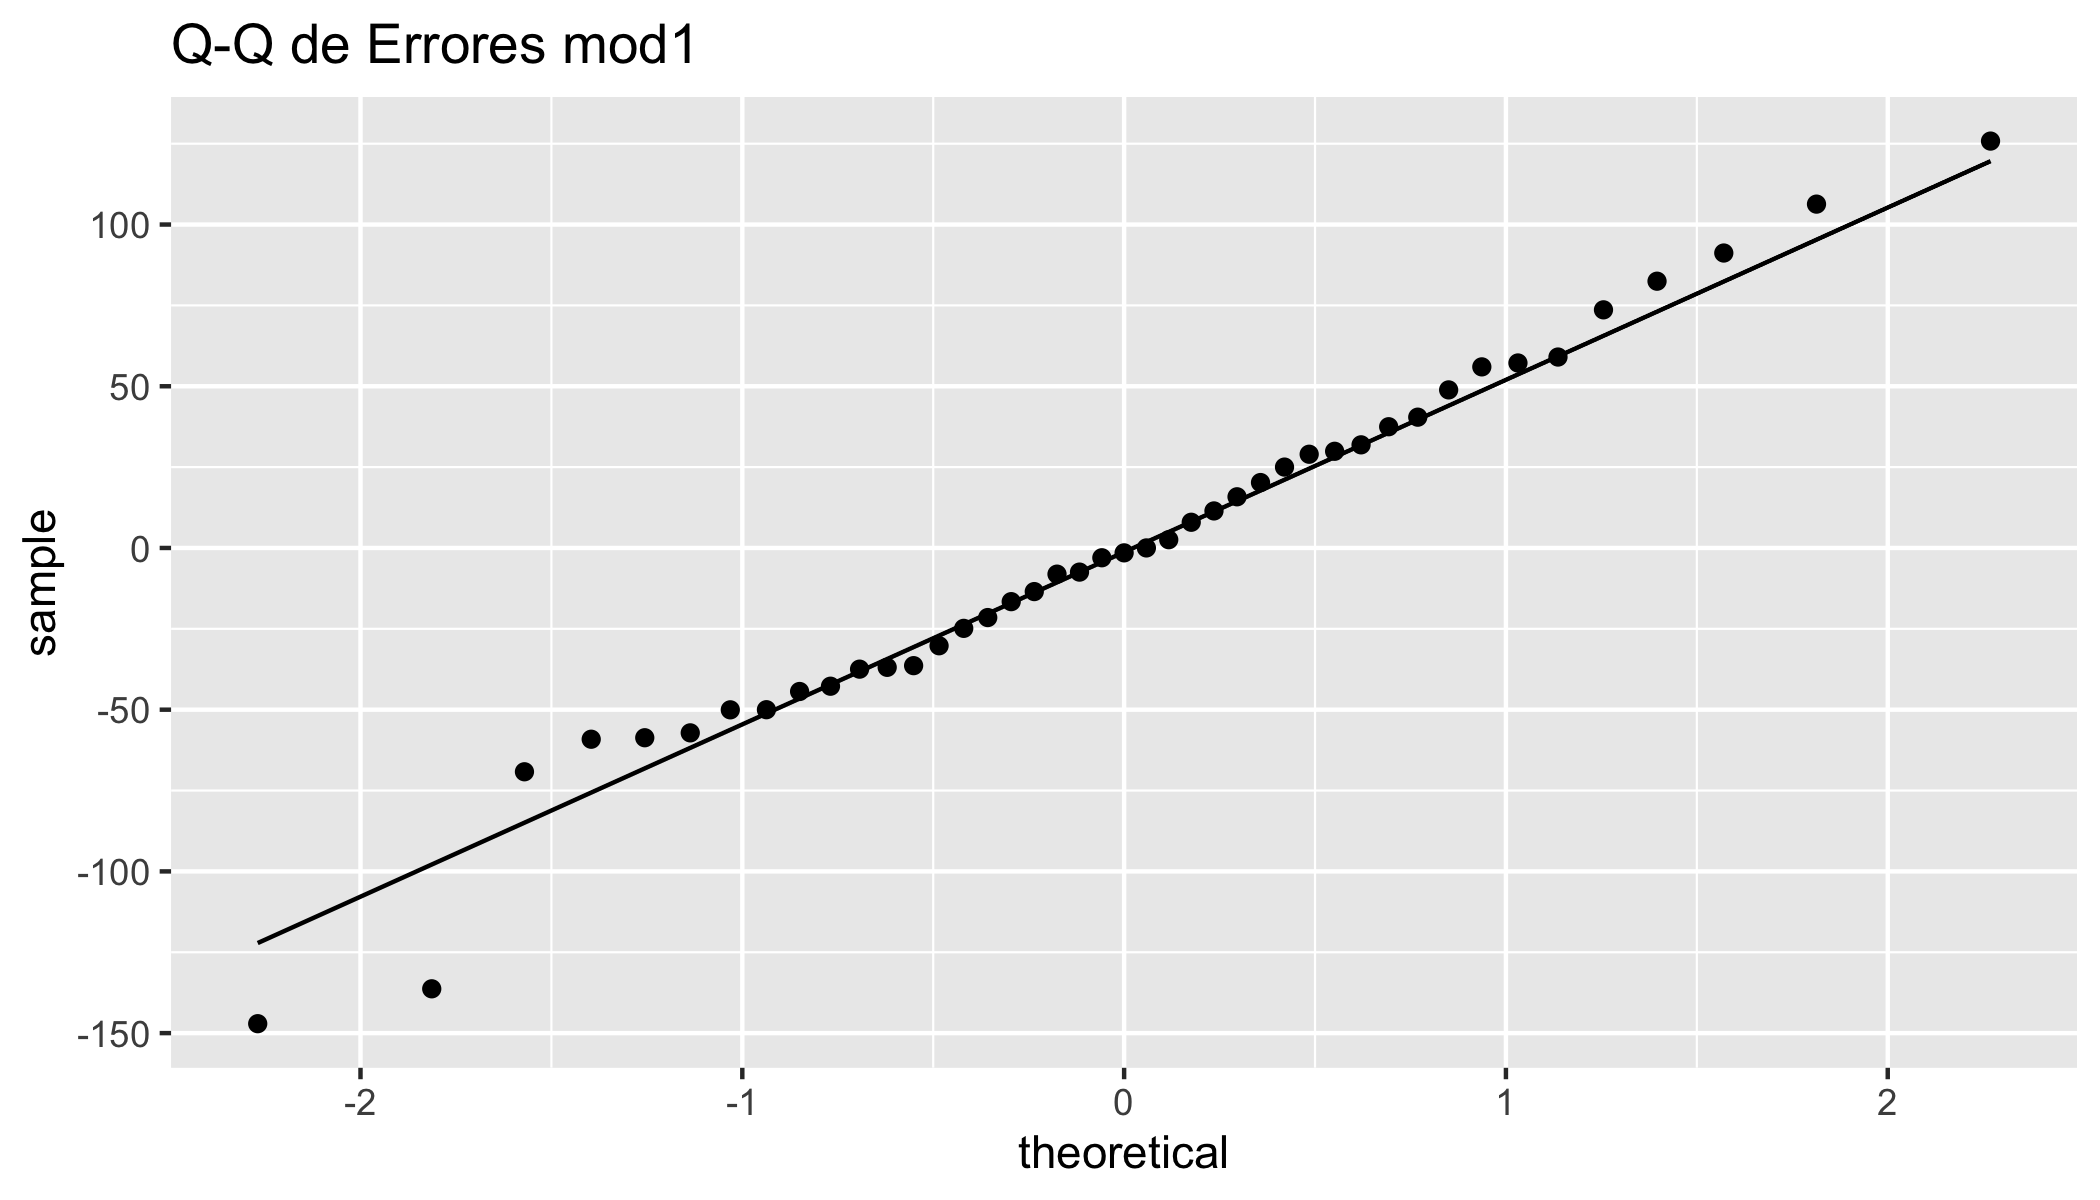

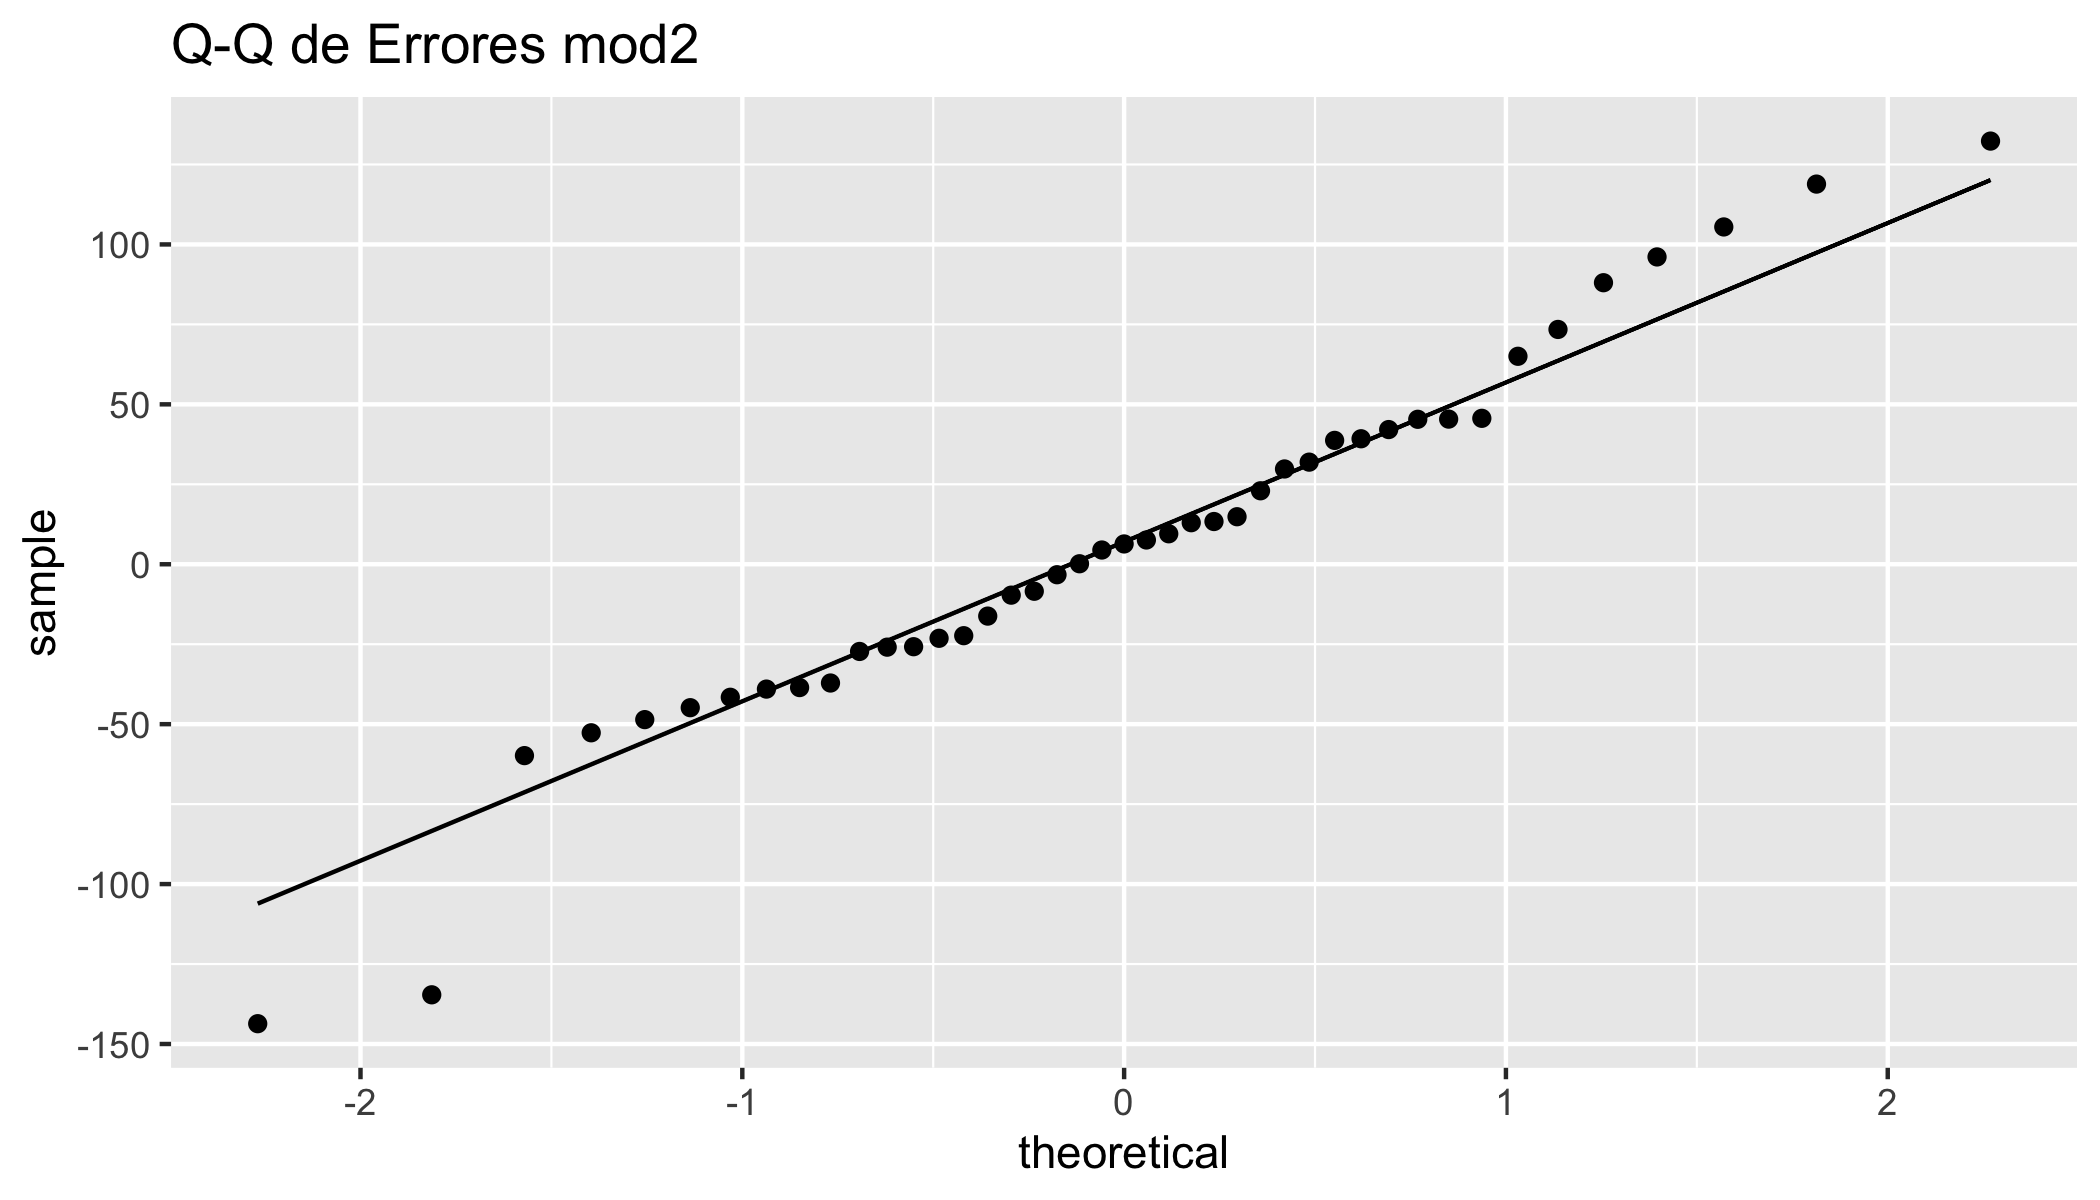

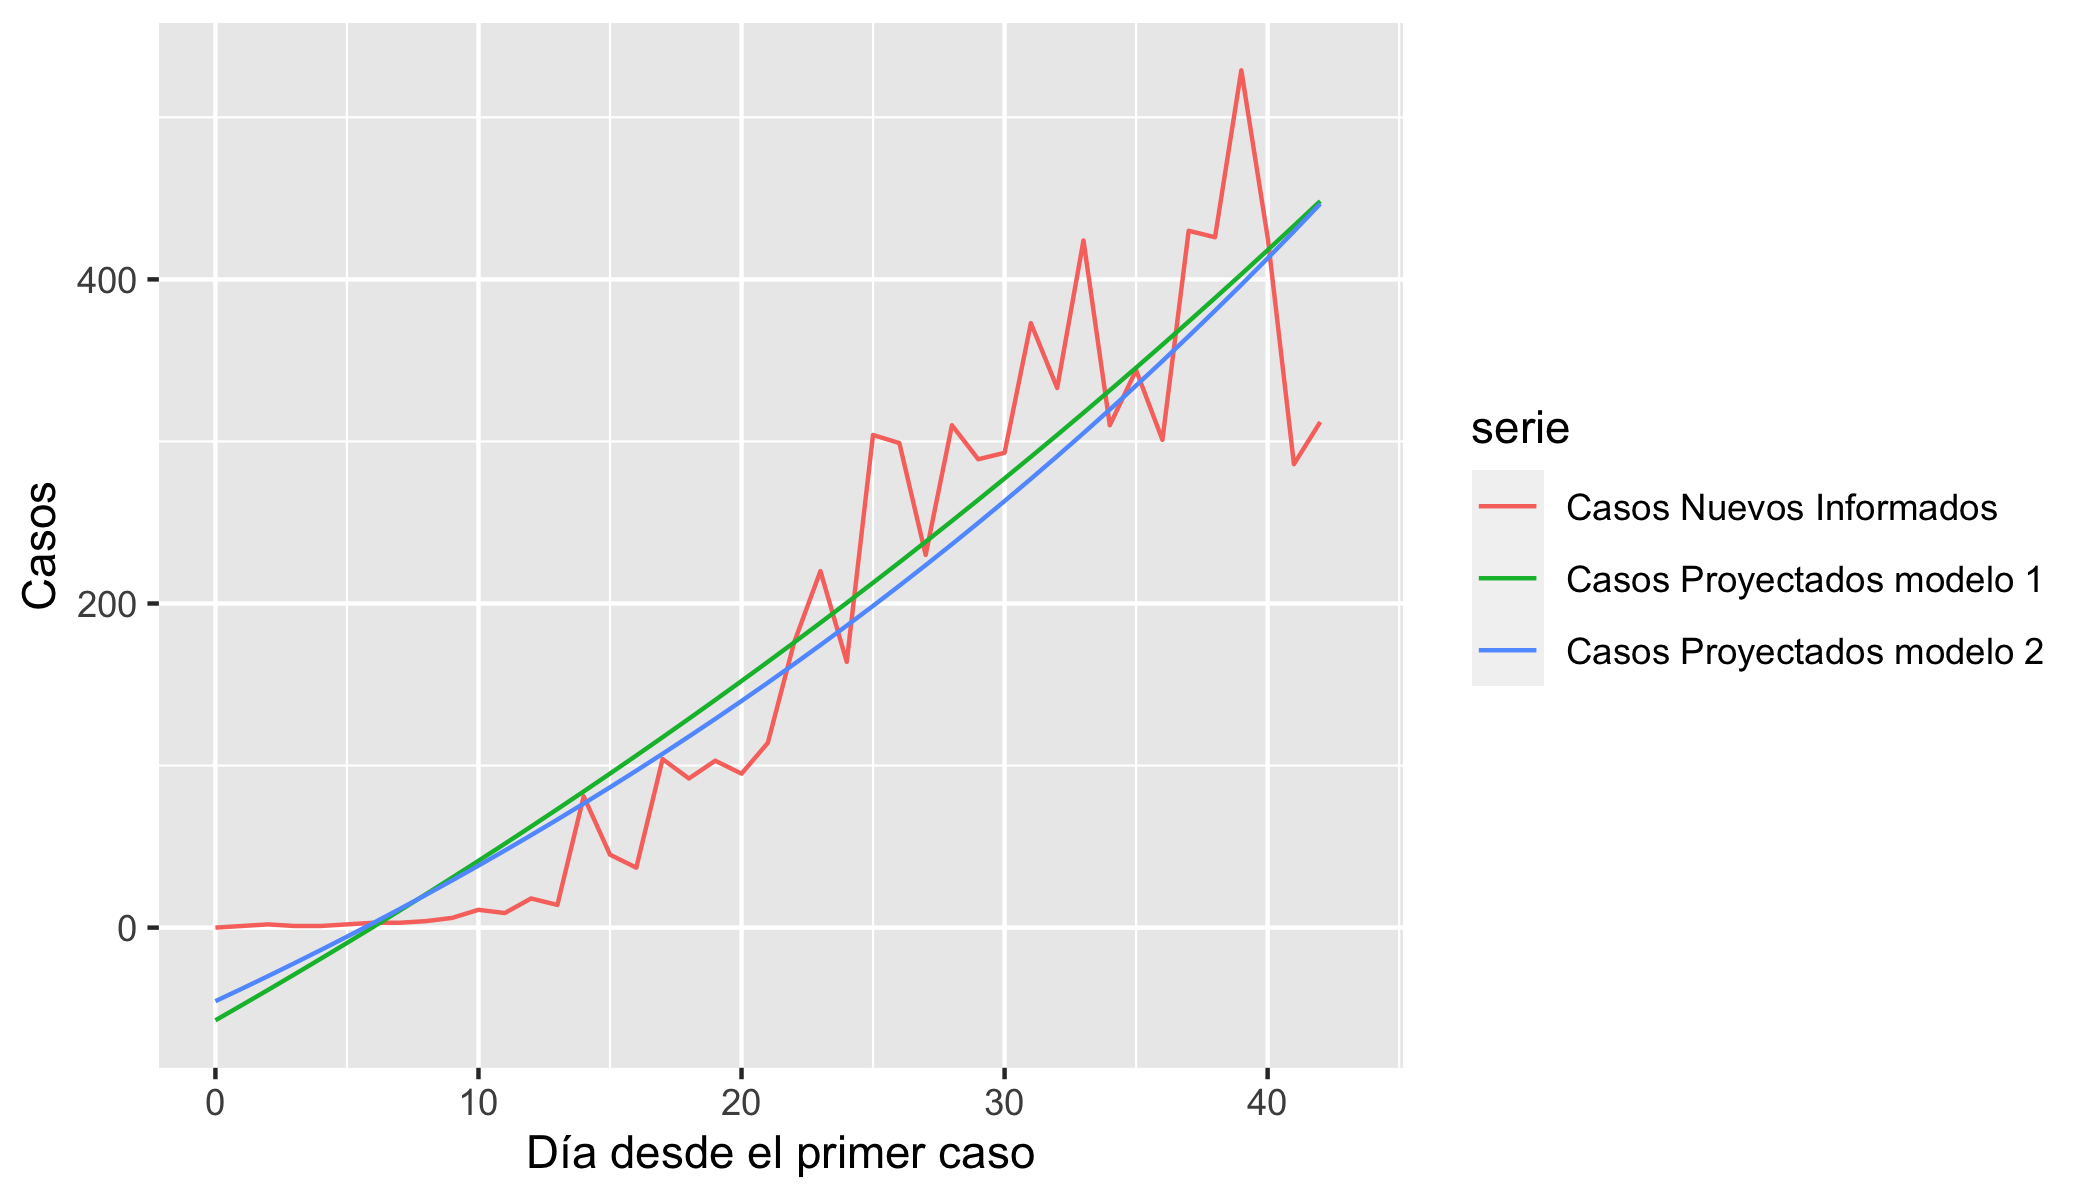

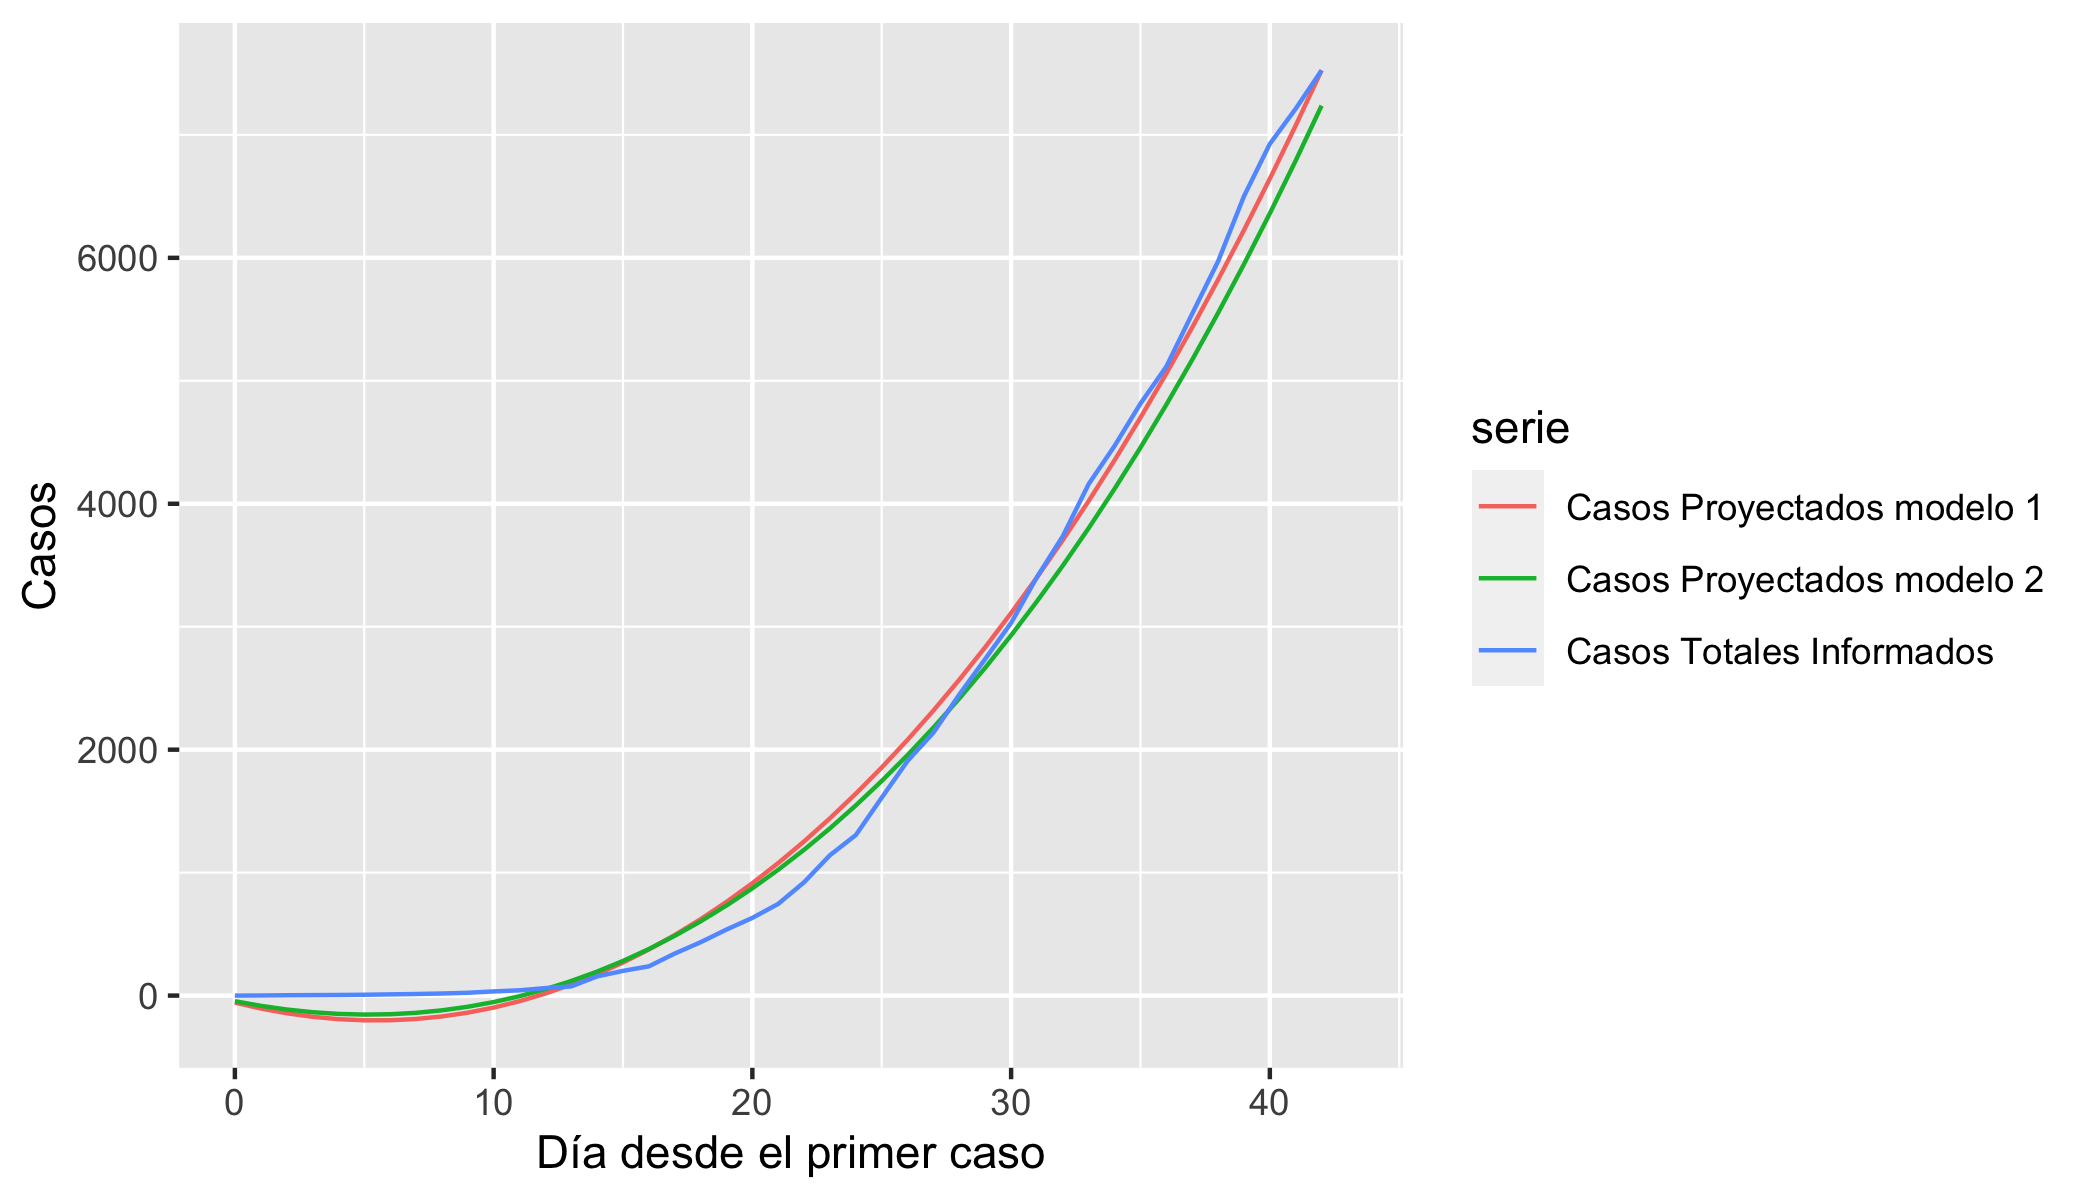

In [384]:
#Modelo 2 predice utilizando todos los datos disponibles
model2 <- nls(Nuevos ~ a*exp(b*Dia)+c, data = data , start = list(a=1,b=0.02, c=1))
model2
shapiro.test(predict(model2, newdata) - data$Nuevos)

model3 <- nls(Nuevos ~ a*exp(b*Dia)+c, data = data[-c(17,26,29,32,34,37,40:42),] , start = list(a=1,b=0.02, c=1))
model3
shapiro.test(predict(model3, newdata) - data$Nuevos)

data <- data %>%
    mutate(Predict1 = predict(model2, newdata),
           Predict1.Tot = cumsum(predict(model2, newdata)),
           Predict2 = predict(model3, newdata),
           Predict2.Tot = cumsum(predict(model3, newdata))
          )

ggplot(data, aes(sample = (Nuevos - Predict1))) + stat_qq() + geom_qq_line() + ggtitle("Q-Q de Errores mod1")

ggplot(data, aes(sample = (Nuevos - Predict2))) + stat_qq() + geom_qq_line() + ggtitle("Q-Q de Errores mod2")

data %>%
    gather(serie, value, Nuevos, Predict1, Predict2) %>%
    mutate(serie = replace(serie, serie == "Nuevos", "Casos Nuevos Informados")) %>%
    mutate(serie = replace(serie, serie == "Predict1", "Casos Proyectados modelo 1")) %>%
    mutate(serie = replace(serie, serie == "Predict2", "Casos Proyectados modelo 2")) %>%
    ggplot(aes(Dia, value, colour = serie)) + geom_line() +
    scale_x_continuous(limits = c(0, x+1)) +
#    scale_y_continuous() +
    xlab("Día desde el primer caso") + ylab("Casos") + theme_grey()

data %>%
    gather(serie, value, Totales, Predict1.Tot, Predict2.Tot) %>%
    mutate(serie = replace(serie, serie == "Totales", "Casos Totales Informados")) %>%
    mutate(serie = replace(serie, serie == "Predict1.Tot", "Casos Proyectados modelo 1")) %>%
    mutate(serie = replace(serie, serie == "Predict2.Tot", "Casos Proyectados modelo 2")) %>%
    ggplot(aes(Dia, value, colour = serie)) + geom_line() +
    scale_x_continuous(limits = c(0, x+1)) +
#    scale_y_continuous() +
    xlab("Día desde el primer caso") + ylab("Casos") + theme_grey()

Warning message:
“Removed 56 row(s) containing missing values (geom_path).”


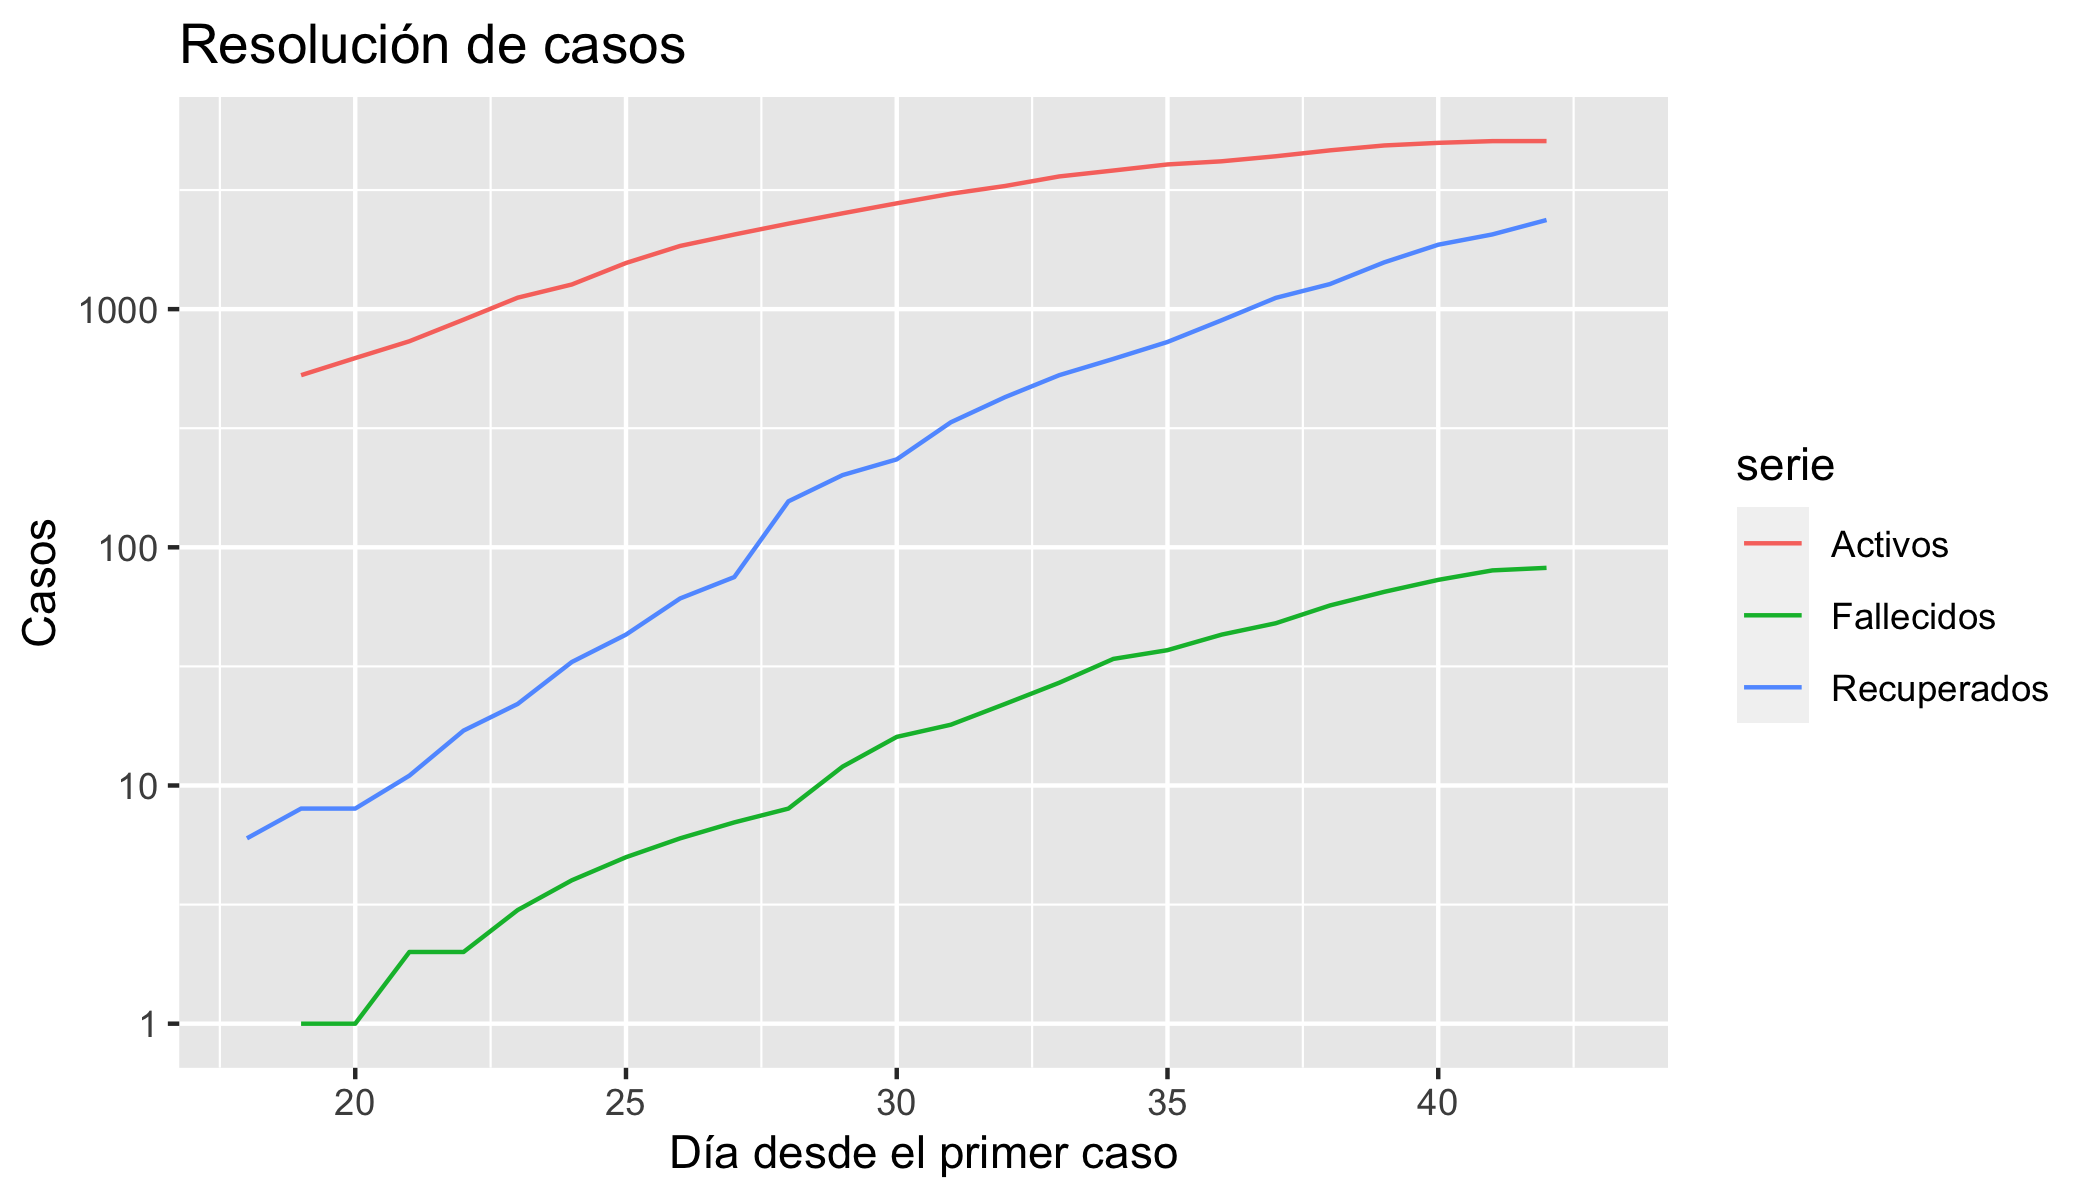

In [401]:
data %>%
    gather(serie, value, Activos, Recuperados, Fallecidos) %>%
    ggplot(aes(Dia, value, colour = serie)) + geom_line() +
    scale_x_continuous(limits = c(18, x+1)) +
    scale_y_continuous(trans='log10') +
    ggtitle("Resolución de casos") +
    xlab("Día desde el primer caso") + ylab("Casos") + theme_grey()

Warning message:
“Removed 46 row(s) containing missing values (geom_path).”


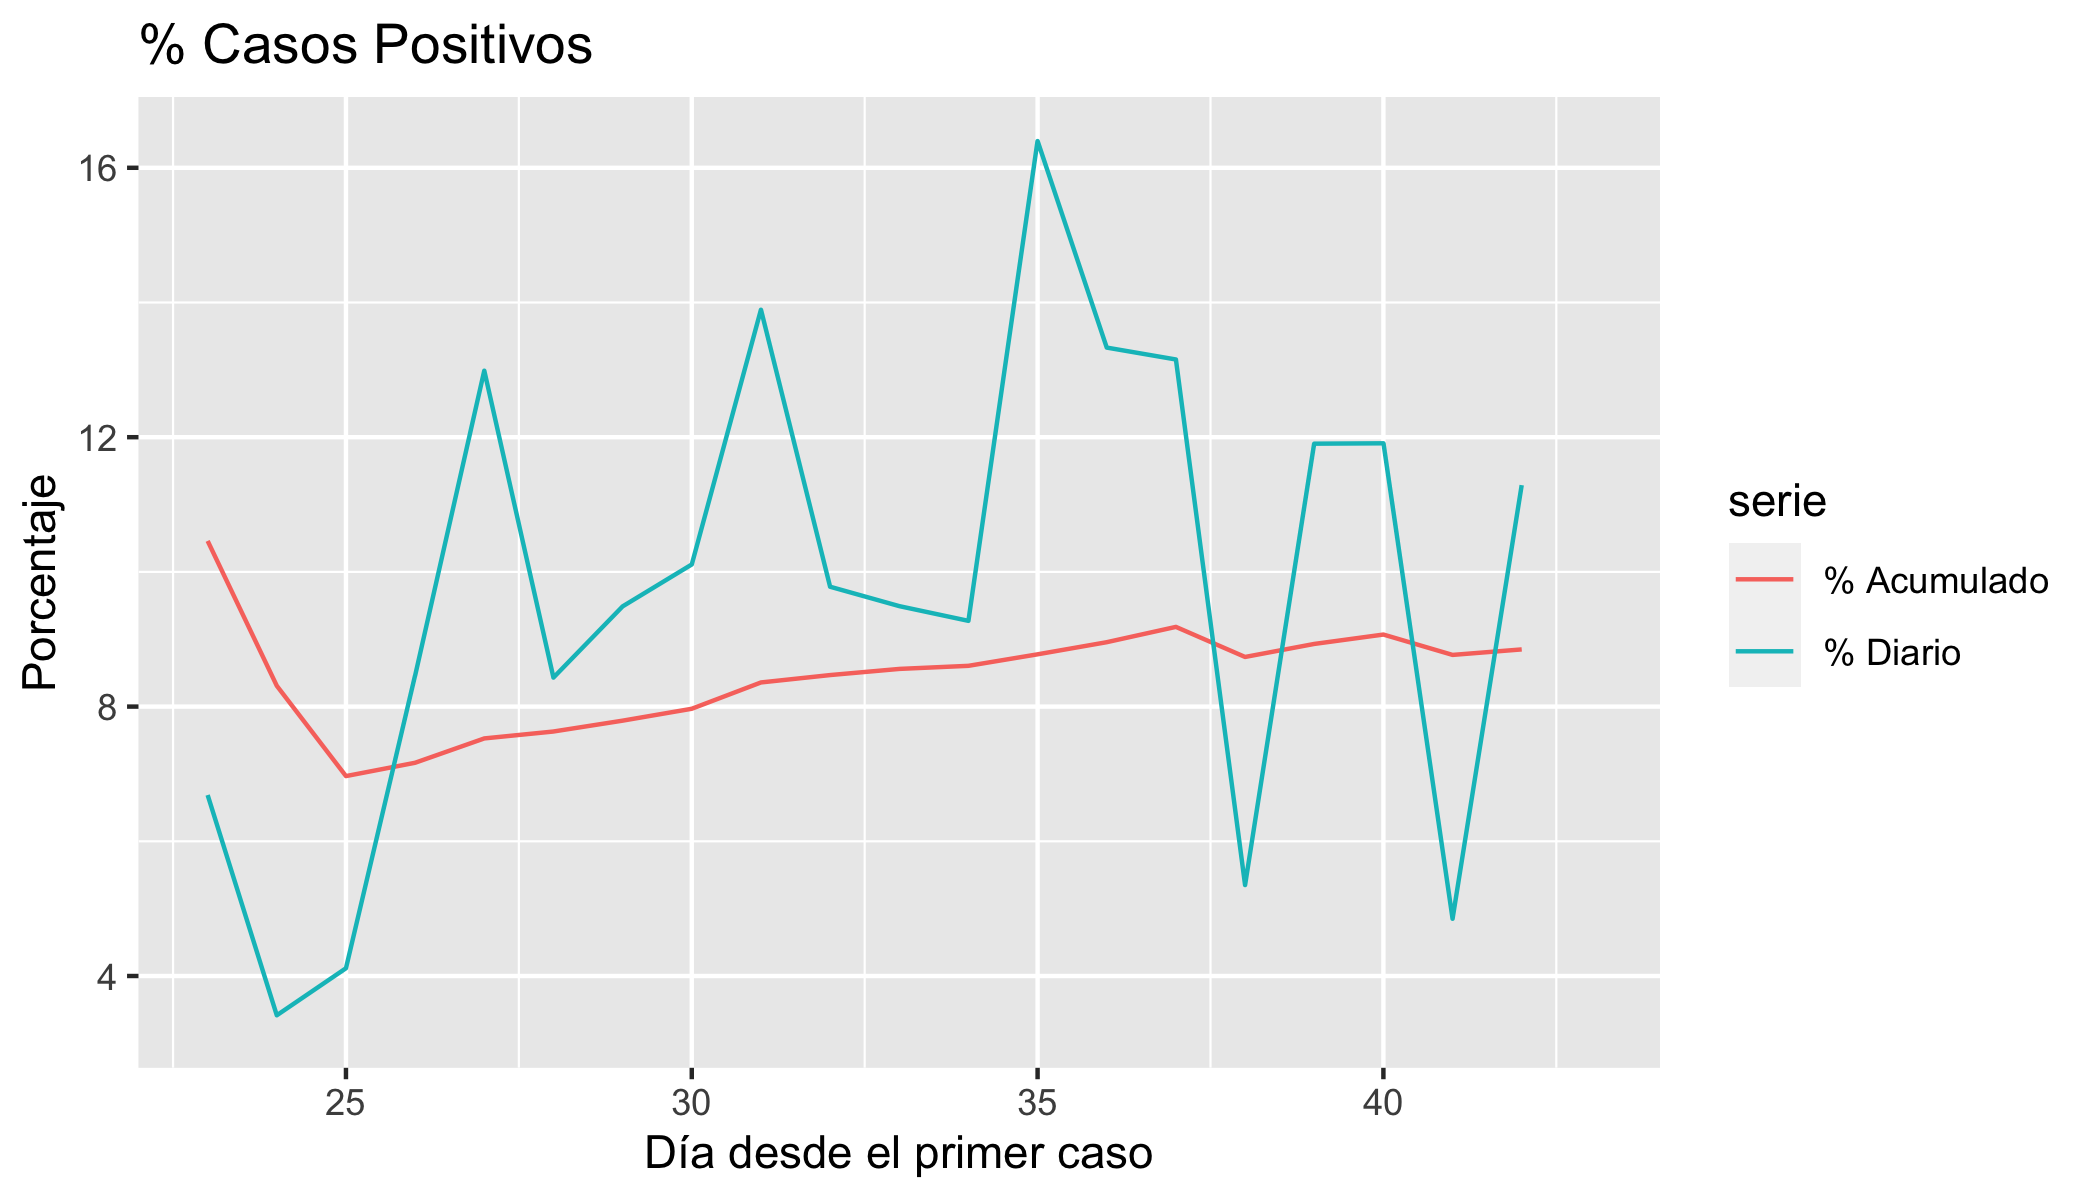

In [386]:
data %>%
    gather(serie, value, positive.rate, positive.rate.cum) %>%
    mutate(serie = replace(serie, serie == "positive.rate", "% Diario")) %>%
    mutate(serie = replace(serie, serie == "positive.rate.cum", "% Acumulado")) %>%
    ggplot(aes(Dia, value, colour = serie)) + geom_line() +
    scale_x_continuous(limits = c(23, x+1)) +
    ggtitle("% Casos Positivos") +
    xlab("Día desde el primer caso") + ylab("Porcentaje") + theme_grey()

Warning message:
“Removed 19 row(s) containing missing values (geom_path).”


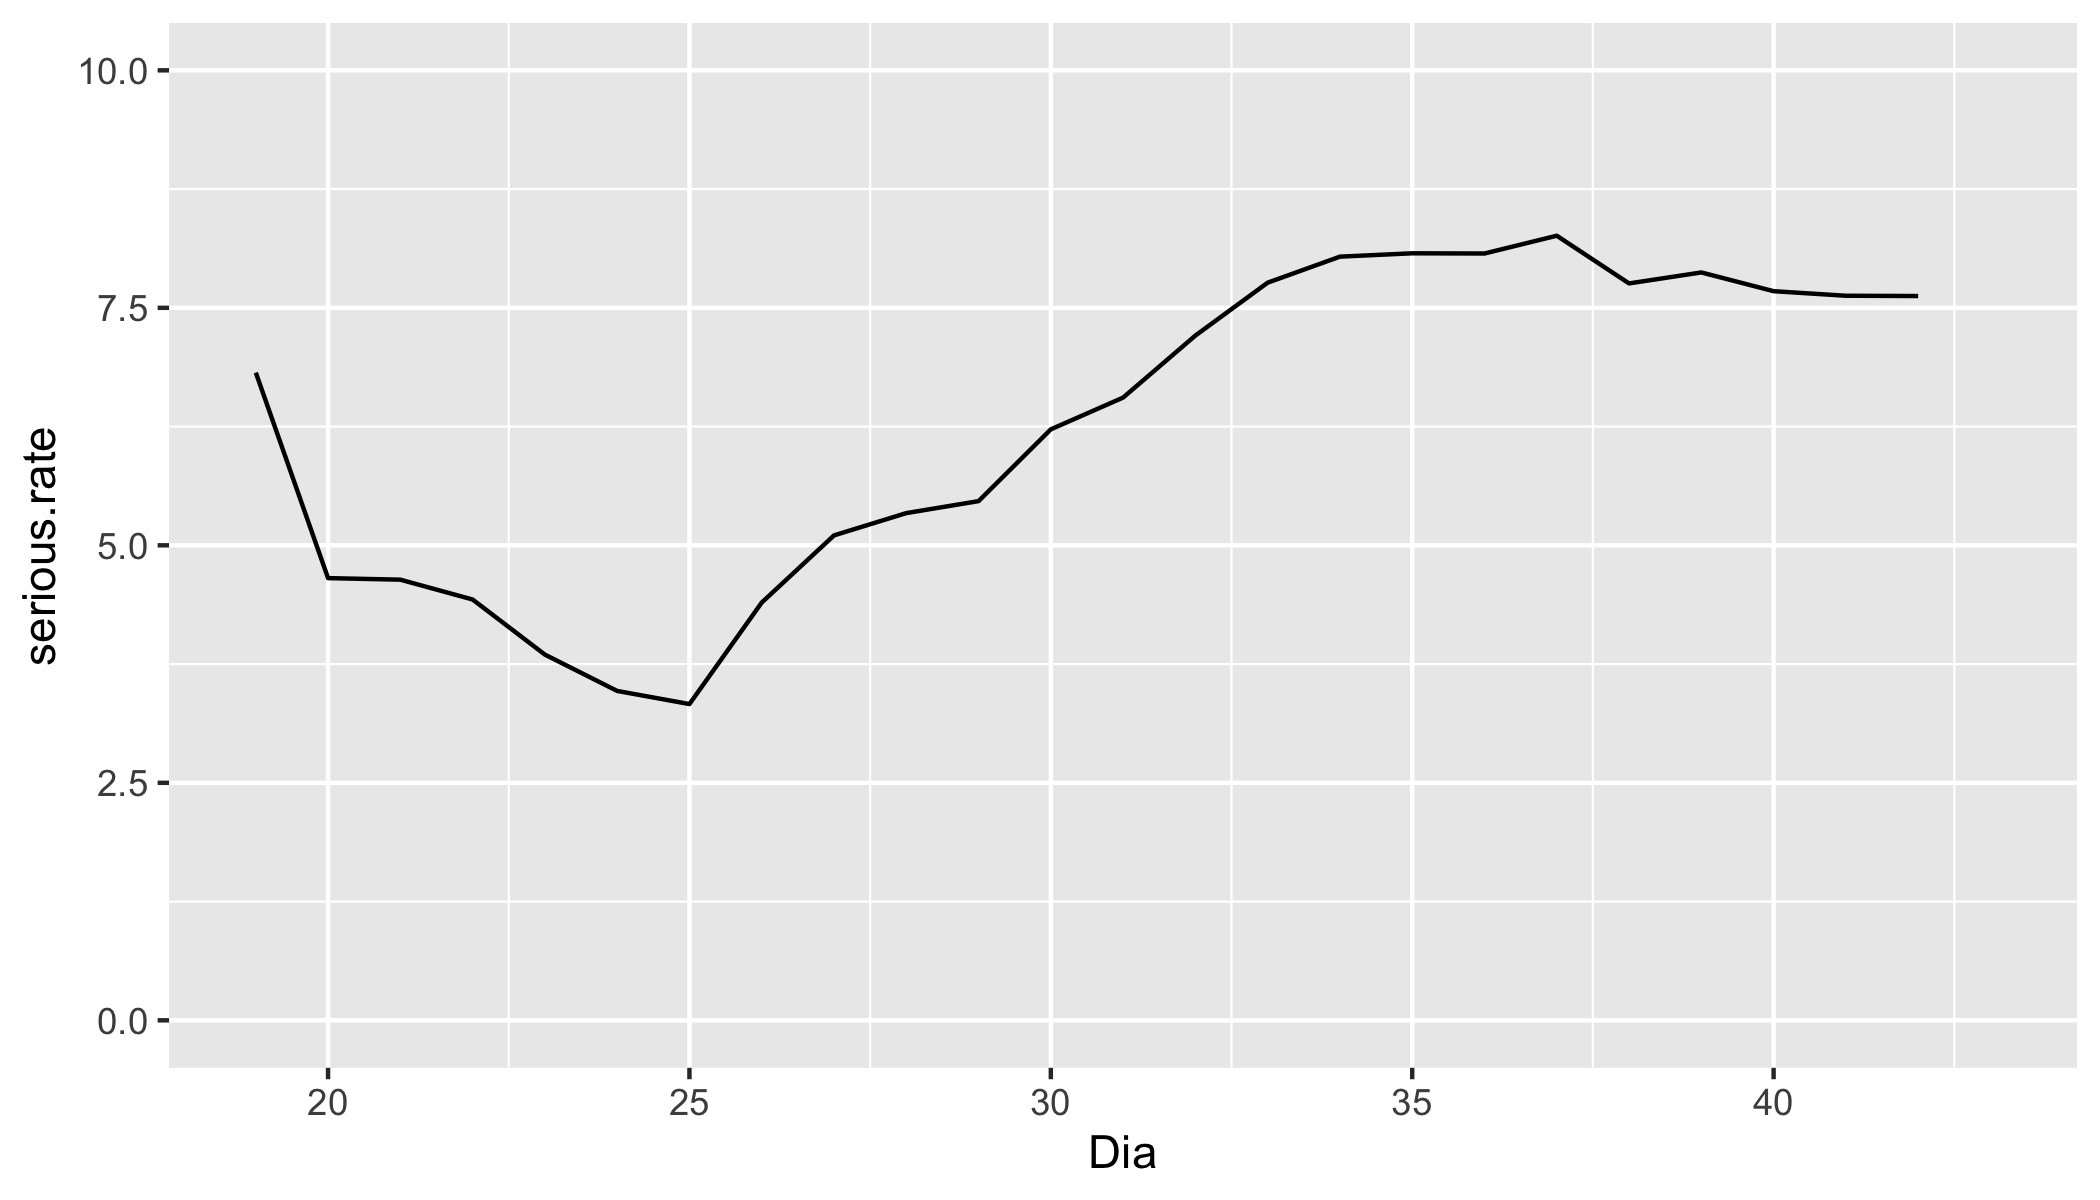

In [387]:
data %>%
    mutate(serious.rate = data$UCI/data$Activos*100) %>%
    ggplot(aes(Dia, serious.rate)) + geom_line() +
    scale_x_continuous(limits = c(19, x+1)) +
    scale_y_continuous(limits = c(0, 10))

Warning message:
“Removed 22 rows containing non-finite values (stat_qq).”
Warning message:
“Removed 22 rows containing non-finite values (stat_qq_line).”


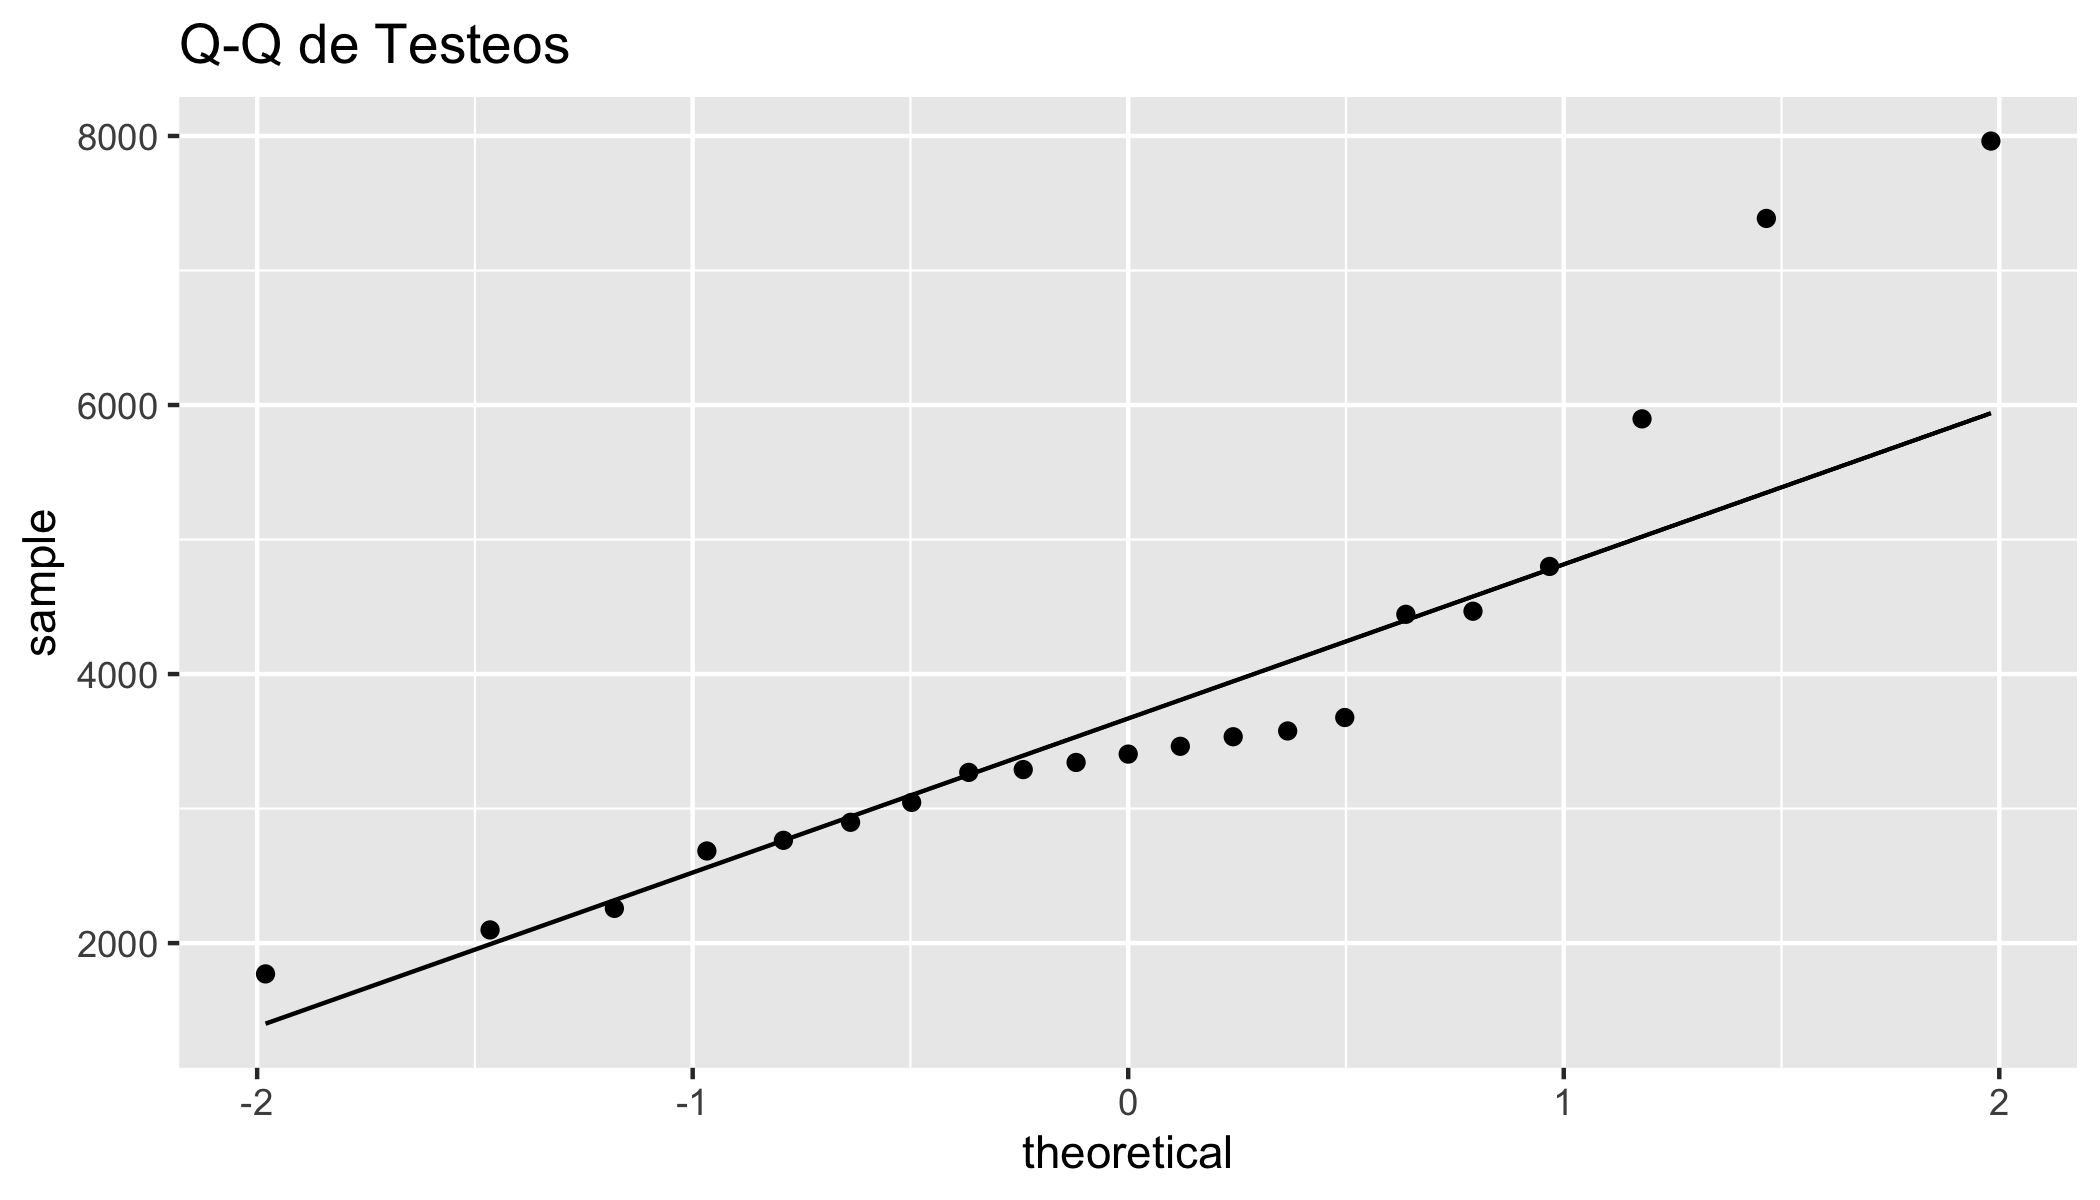

In [388]:
data %>%
    ggplot(aes(sample = (Testeos))) + stat_qq() + geom_qq_line() + ggtitle("Q-Q de Testeos")

Warning message:
“Removed 19 row(s) containing missing values (geom_path).”


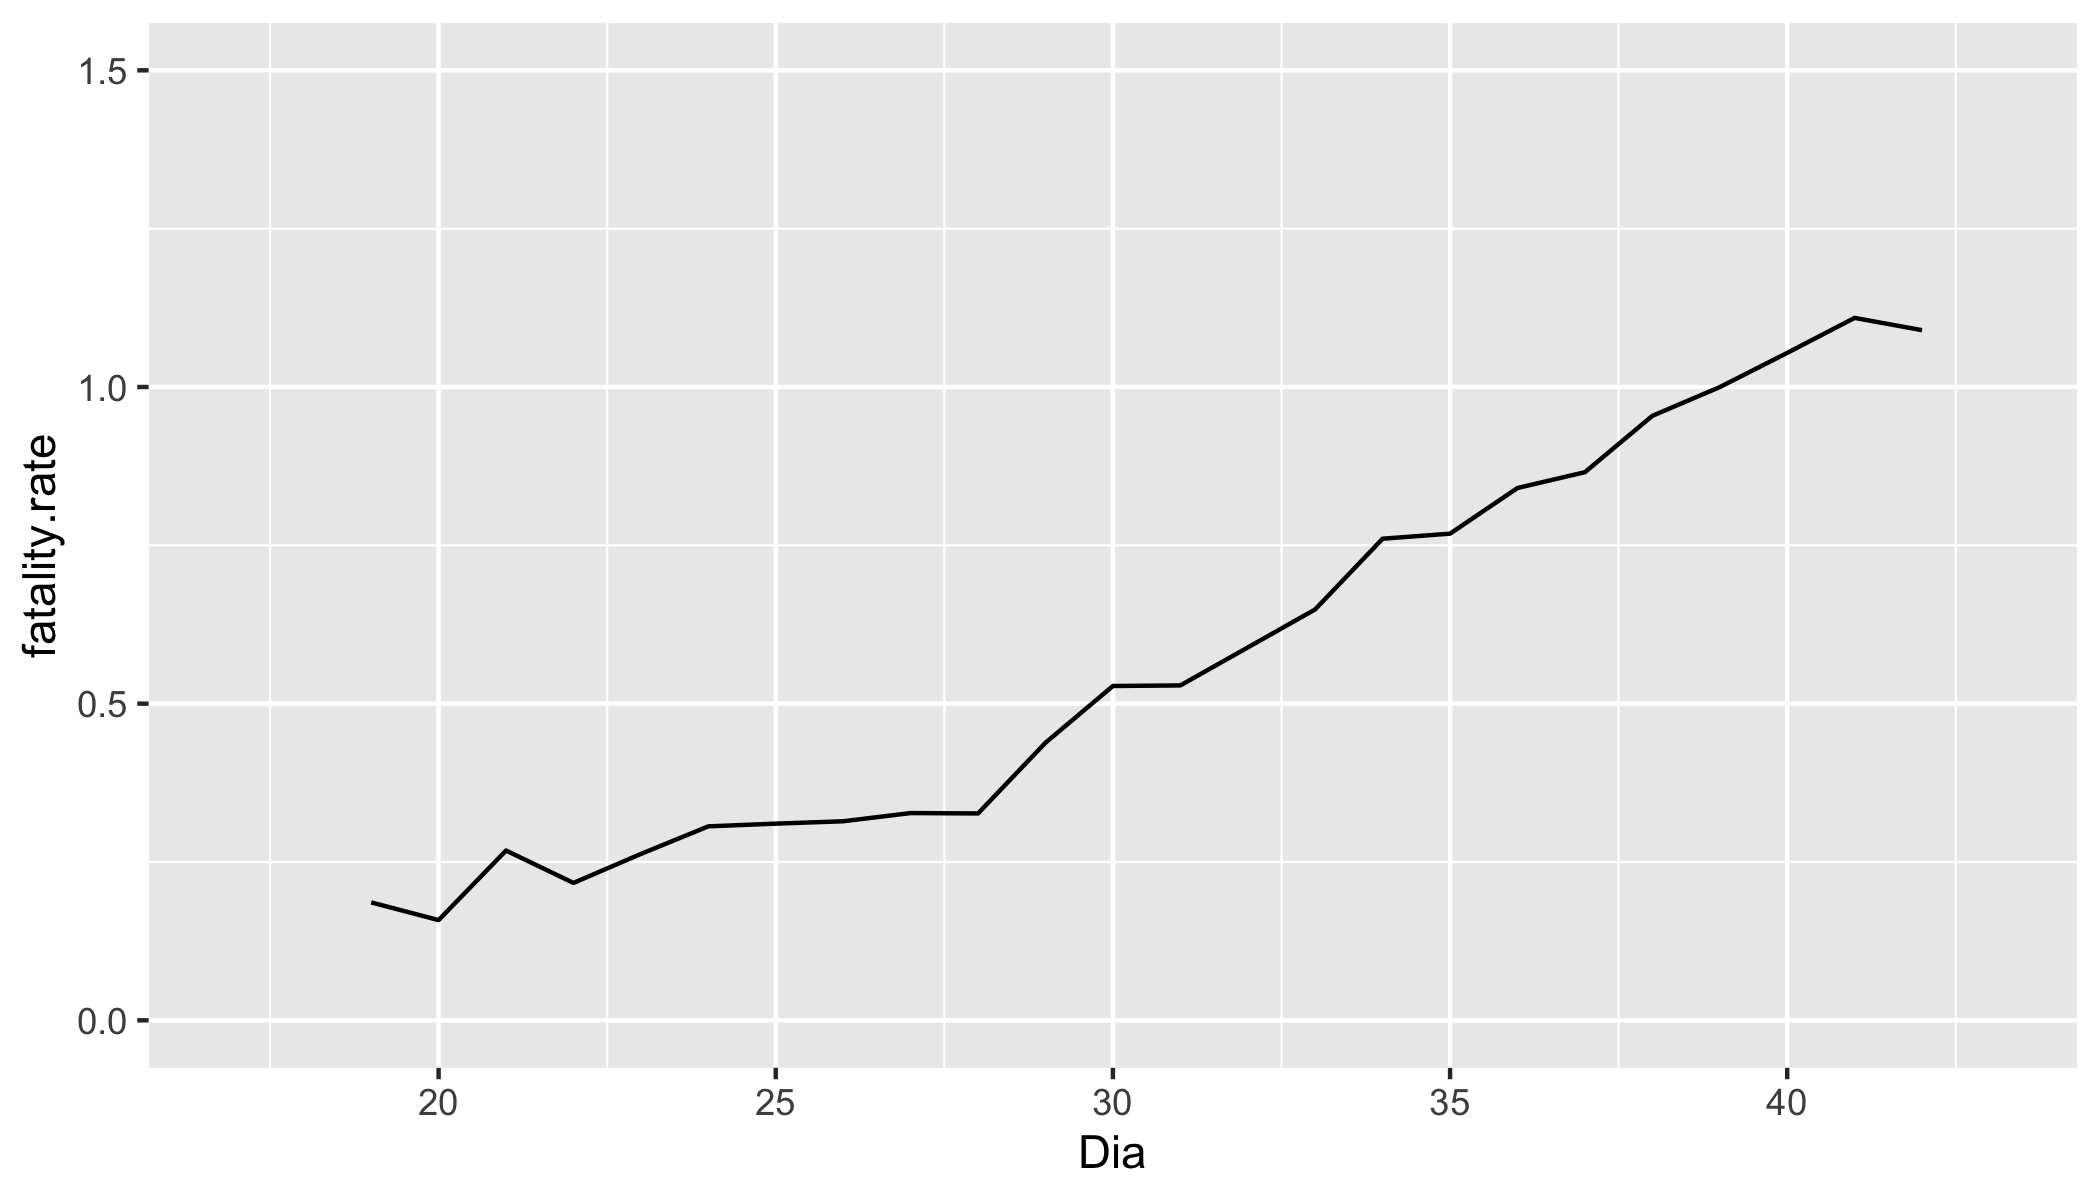

In [389]:
data %>%
    ggplot(aes(Dia, fatality.rate)) + geom_line() +
    scale_x_continuous(limits = c(17, x+1)) +
    scale_y_continuous(limits = c(0, 1.5))

Selecting by Reales



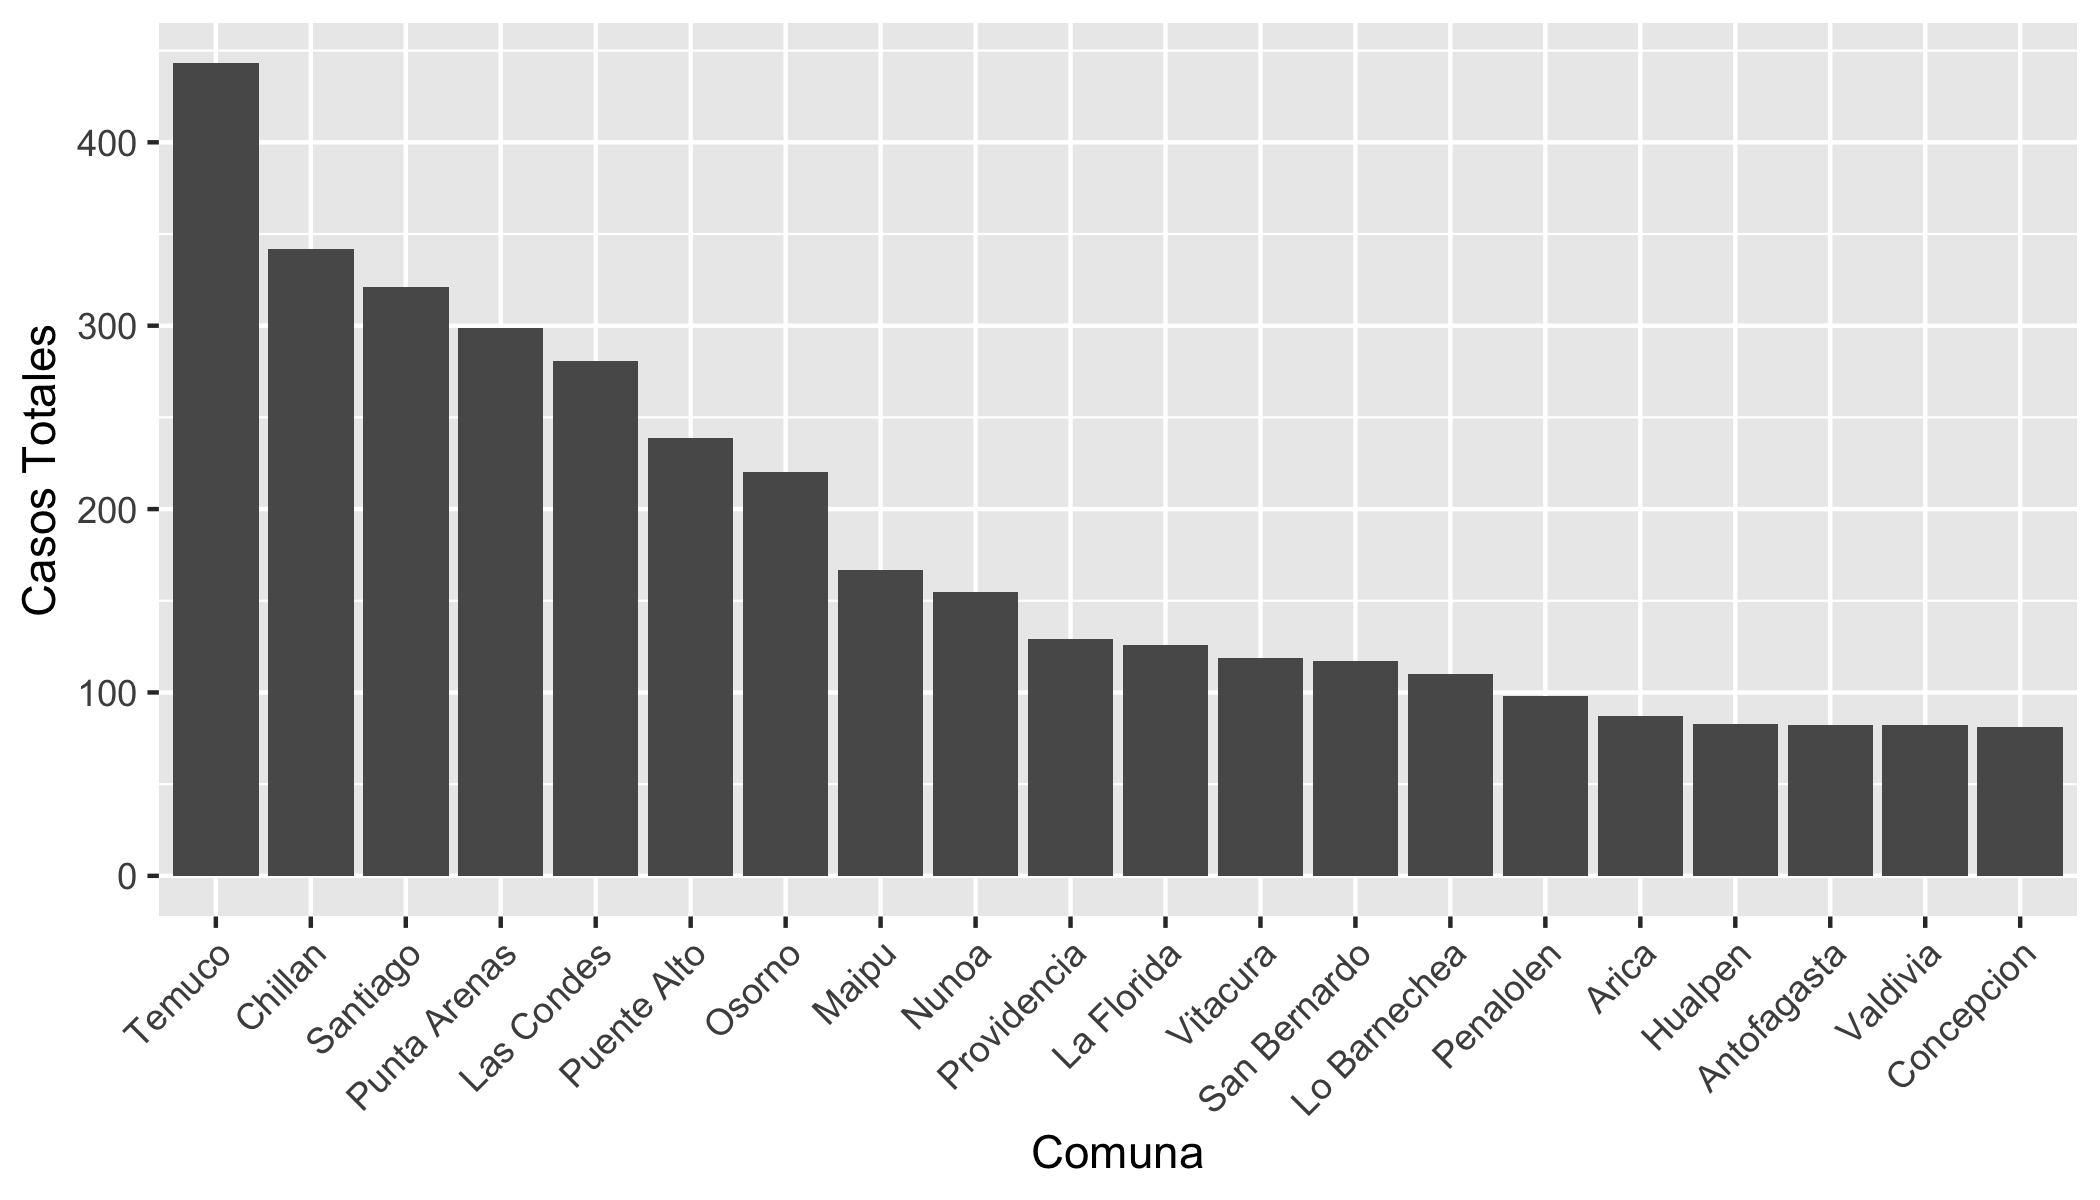

In [390]:
data_epi %>%
    select(Comuna, Reales) %>%
    top_n(20) %>%
    ggplot(aes(x=reorder(Comuna,-Reales),y=Reales)) + 
    geom_bar(stat = 'identity') +
    ylab("Casos Totales") +
    xlab("Comuna") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

Selecting by Tasa



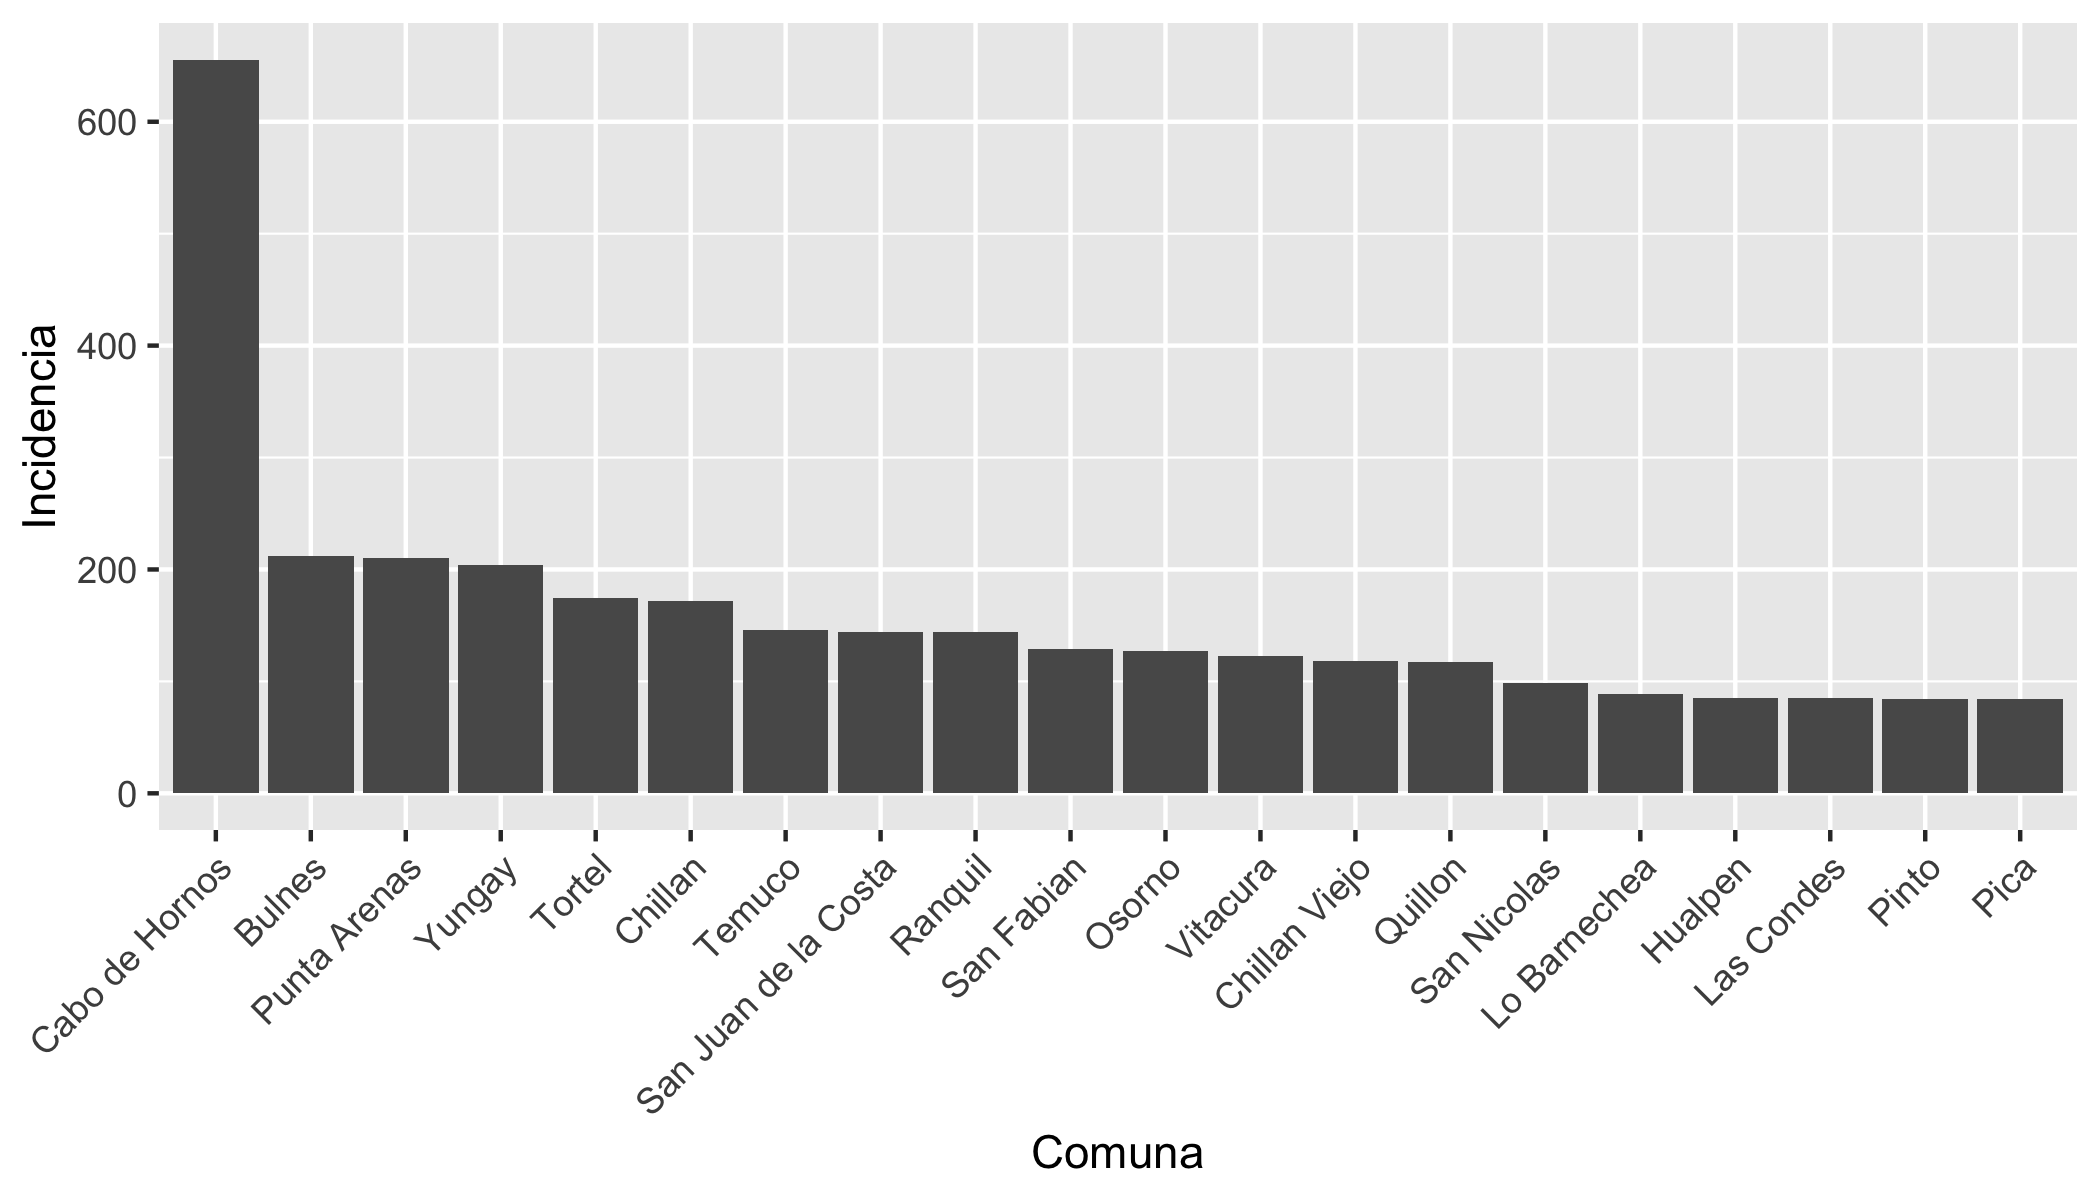

In [391]:
data_epi %>%
    select(Comuna, Tasa) %>%
    top_n(20) %>%
    ggplot(aes(x=reorder(Comuna,-Tasa),y=Tasa)) + 
    geom_bar(stat = 'identity') +
    ylab("Incidencia") +
    xlab("Comuna") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

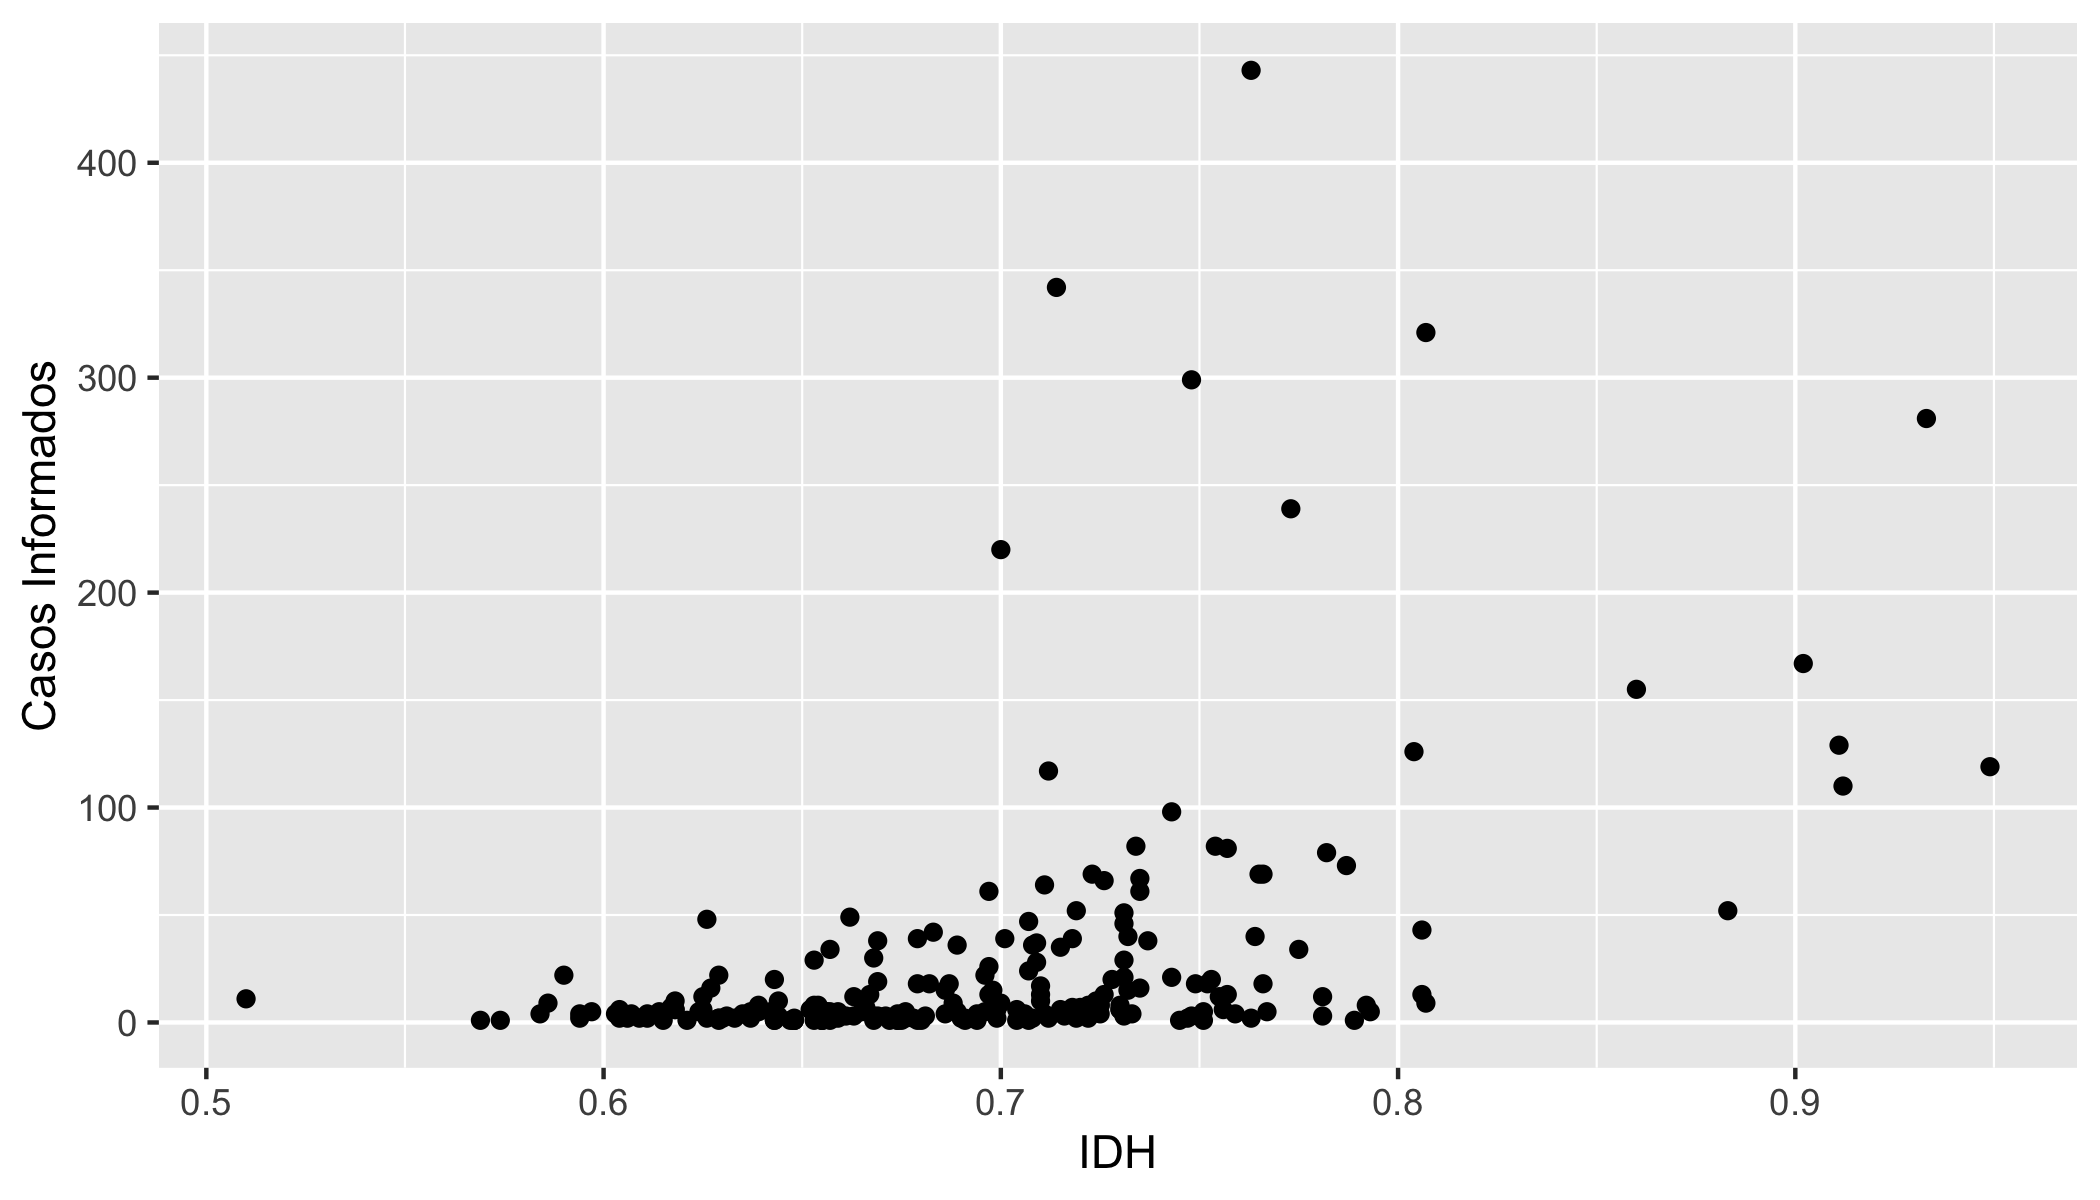

In [448]:
data_epi %>%
    filter(Reales > 0, IDH <20) %>%
    ggplot(aes(IDH, Reales)) + 
    ylab('Casos Informados') +
#    scale_x_continuous(trans='log10') + 
#    scale_y_continuous(trans='log10') + 
    geom_point()

In [452]:
data_epi %>%
#    filter(densidad >= 100) %>%
    filter(Reales > 200) %>%
    filter(IDH < 0.9) %>%
    mutate(indice1 = Tasa/densidad) %>%
    mutate(indice2 = Reales/superficie) %>%
    arrange(desc(indice1)) %>%
    select(Comuna, Region,IDH, Poblacion,Tasa, Reales, densidad, indice1, indice2)

Comuna,Region,IDH,Poblacion,Tasa,Reales,densidad,indice1,indice2
<fct>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Punta Arenas,Magallanes y la Antartica,0.748,141984,210.6,299,7.955935,26.470805020,0.01675417
Osorno,Los Lagos,0.700,173410,126.9,220,182.344900,0.695933914,0.23133544
Chillan,Nuble,0.714,198624,172.2,342,388.544601,0.443192363,0.66901408
Temuco,La Araucania,0.763,302931,146.2,443,652.868534,0.223934823,0.95474138
Puente Alto,Metropolitana,0.773,645909,37.0,239,7339.875000,0.005040958,2.71590909
Santiago,Metropolitana,0.807,503147,63.8,321,21687.370690,0.002941804,13.83620690


In [395]:
dias <- (tail(data$Dia, n=1) + 15)
proy <- data.frame(Dia=c(0:dias))

#proy$Fecha <- seq.Date(from=as.Date("2020-03-02"), by='day', length.out = x+1)
#proy$Casos <- cumsum(predict(model2, proy))

proy %>%
    mutate(Fecha = seq.Date(from=as.Date("2020-03-02"), by='day', length.out = dias+1)) %>%
    mutate(CasosTotales = cumsum(round(predict(model2, proy),0))) %>%
    mutate(Nuevos = round(predict(model2, proy),0)) %>%
    slice(tail(row_number(), 16))


Dia,Fecha,CasosTotales,Nuevos
<int>,<date>,<dbl>,<dbl>
42,2020-04-13,7525,448
43,2020-04-14,7989,464
44,2020-04-15,8468,479
45,2020-04-16,8963,495
46,2020-04-17,9474,511
47,2020-04-18,10001,527
48,2020-04-19,10545,544
49,2020-04-20,11105,560
50,2020-04-21,11682,577


In [396]:
data %>%
    slice(tail(row_number(), 4))

Fecha,Dia,Nuevos,Recuperados,Fallecidos,Testeos,Testeos.Totales,UCI,Totales,fatality.rate,positive.rate,positive.rate.cum,Activos,Predict1,Predict1.Tot,Predict2,Predict2.Tot
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2020-04-10,39,529,1571,65,4444,72797,383,6501,0.9998462,11.903690,8.930313,4865,403.1934,6225.561,396.6842,5948.619
2020-04-11,40,426,1864,73,3577,76374,383,6927,1.0538473,11.909421,9.069841,4990,418.0505,6643.611,413.0075,6361.626
2020-04-12,41,286,2059,80,5897,82271,387,7213,1.1091086,4.849924,8.767366,5074,433.0861,7076.698,429.6509,6791.277
2020-04-13,42,312,2367,82,2764,85035,387,7525,1.0897010,11.287988,8.849297,5076,448.3025,7525.000,446.6207,7237.898


In [397]:
coef(summary(model2))

,Estimate,Std. Error,t value,Pr(>|t|)
a,775.55210836,898.41754424,0.8632424,0.3931509
b,0.01194913,0.01089801,1.0964500,0.2794393
c,-832.75149770,917.12231151,-0.9080048,0.3693139


In [399]:
summary(model2)


Formula: Nuevos ~ a * exp(b * Dia) + c

Parameters:
    Estimate Std. Error t value Pr(>|t|)
a  775.55211  898.41754   0.863    0.393
b    0.01195    0.01090   1.096    0.279
c -832.75150  917.12231  -0.908    0.369

Residual standard error: 58.72 on 40 degrees of freedom

Number of iterations to convergence: 11 
Achieved convergence tolerance: 1.646e-06
